In [157]:
!pip install -q -U vtk numpy matplotlib pydicom scipy stl

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import vtk
import os
import matplotlib.pyplot as plt
from pydicom import dcmread
import numpy as np
import pydicom
from stl import mesh
from scipy.ndimage import zoom

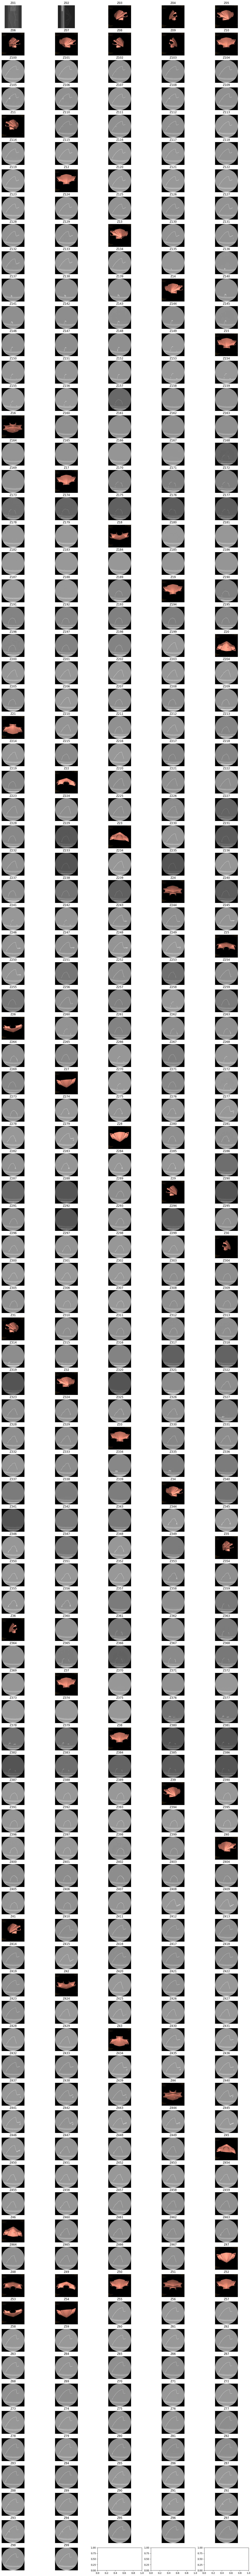

In [ ]:
dicom_files = "data/dicom_files/"

# show all dicom files in grid
def show_dicom_files():
    files = os.listdir(dicom_files)
    files = [f for f in files]
    num_files = len(files)
    files.sort()
    # show five images in a row
    cols = 5
    rows = num_files // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize=(20, 200))
    for i, f in enumerate(files):
        ax = axs[i // cols, i % cols]
        img = dcmread(dicom_files + f).pixel_array
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f)
    plt.show()

show_dicom_files()

In [ ]:


def resample_slice(slice_data, original_spacing, target_spacing, target_shape):
    """Resamples a 2D slice to a target shape and spacing."""
    resize_factors = [
        original_spacing[0] / target_spacing[0],  # x-scaling
        original_spacing[1] / target_spacing[1],  # y-scaling
    ]
    resized_data = zoom(slice_data, resize_factors, order=3)  # Cubic interpolation
    # Crop or pad to match the exact target shape
    resized_data = resize_or_pad(resized_data, target_shape)
    return resized_data

def resize_or_pad(image, target_shape):
   """Resizes an image to the target shape by cropping or padding."""
   current_shape = image.shape
   row_pad = max(0, target_shape[0] - current_shape[0])
   col_pad = max(0, target_shape[1] - current_shape[1])
   row_pre_pad = row_pad // 2
   row_post_pad = row_pad - row_pre_pad
   col_pre_pad = col_pad // 2
   col_post_pad = col_pad - col_pre_pad
   padded_image = np.pad(image, ((row_pre_pad, row_post_pad), (col_pre_pad, col_post_pad)), mode='constant')
   cropped_image = padded_image[:target_shape[0], :target_shape[1]]
   return cropped_image

# Example usage (inside your DICOM loading loop):
target_shape = (512, 512)  # Example target shape
target_spacing = (1.0, 1.0)  # Example target spacing (adjust as needed)


def dicom_to_stl(dicom_dir, output_stl_file):
    """
    Converts a directory of DICOM files to a single STL file.

    Args:
        dicom_dir: Path to the directory containing the DICOM files.
        output_stl_file: Path to save the generated STL file.
    """

    # 1. Load DICOM files and extract pixel data
    slices = []
    for filename in os.listdir(dicom_dir):
        filepath = os.path.join(dicom_dir, filename)
        dataset = pydicom.dcmread(filepath)
        slices.append(dataset)

    # Sort slices by Instance Number to ensure correct order
    slices.sort(key=lambda x: x.InstanceNumber)
    # Get spacing between pixels (adjust if needed for your DICOM data)
    try:
        x_spacing = slices[-1].PixelSpacing[0]
        y_spacing = slices[-1].PixelSpacing[1]
        z_spacing = slices[-1].SliceThickness  # May need adjustment for some datasets
    except AttributeError:
        # Handle cases where spacing information is not available
        x_spacing = 1
        y_spacing = 1
        z_spacing = 1
        print("Warning: Spacing information not found in DICOM headers. Assuming 1mm for all dimensions.")

    # Get pixel data and spacing information
    pixel_arrays = []
    resampled_slices = []
    for s in slices:
        pixel_array = s.pixel_array
        if pixel_array.ndim == 3:
            continue
        elif pixel_array.ndim == 2:
            selected_channel = pixel_array
        else:
            raise ValueError("Unsupported image dimensions")
        resampled_slice = resample_slice(selected_channel, [x_spacing, y_spacing], [x_spacing, y_spacing], target_shape)
        resampled_slices.append(resampled_slice)
        pixel_arrays.append(selected_channel)
    
    resampled_slices = resampled_slices[3:]

    # 2. Thresholding and Marching Cubes (using a simple threshold for demonstration)
    # You might need to adjust the threshold based on your data 
    threshold = 200  # Example threshold value

    # Create a 3D binary mask based on threshold
    mask = np.stack([arr > threshold for arr in resampled_slices]).astype(np.uint8)

    # 3. Generate STL mesh using marching cubes (using scikit-image)
    from skimage import measure
    verts, faces, _, _ = measure.marching_cubes(mask, level=0.5)

    # Apply scaling based on DICOM spacing (important for accurate dimensions)
    verts[:, 0] *= x_spacing
    verts[:, 1] *= y_spacing
    verts[:, 2] *= z_spacing

    # 4. Save the mesh to an STL file
    mesh_obj = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    mesh_obj.vectors = verts[faces]
    mesh_obj.save(output_stl_file)

    print(f"STL file saved to: {output_stl_file}")

    return resampled_slices


def visualize_stl_vtk(stl_file):
    """Visualizes an STL file using VTK."""
    reader = vtk.vtkSTLReader()
    reader.SetFileName(stl_file)
    reader.Update()

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    renderer = vtk.vtkRenderer()
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    iren = vtk.vtkRenderWindowInteractor()
    iren.SetRenderWindow(renderWindow)

    renderer.AddActor(actor)
    renderer.SetBackground(0.1, 0.2, 0.3)  # Set background color

    renderWindow.Render()
    iren.Start()

def plot_resampled_slices(resampled_slices):
    """Plots a grid of resampled slices."""
    num_slices = len(resampled_slices)
    cols = 5
    rows = num_slices // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize=(20, 200))
    for i, slice_data in enumerate(resampled_slices):
        ax = axs[i // cols, i % cols]
        ax.imshow(slice_data, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Slice {i}")
    plt.show()


# Example usage:
dicom_directory = "data/dicom_files/"
output_filename = "output.stl"
resampled_slices = dicom_to_stl(dicom_directory, output_filename)
# plot_resampled_slices(resampled_slices)
visualize_stl_vtk(output_filename)

STL file saved to: output.stl
